### dummy

### dummy

### dummy

### dummy

## Load libraries

In [9]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import keras
from keras.models import load_model
import tensorflow as tf

from scipy.stats import skew, kurtosis

## Load dataset

In [2]:
data_path = pd.read_csv("data_path.csv")
dataset_list = []
for i in range(len(data_path)):
    dataset_list.append(data_path.iloc[i,1].split("/")[1].lower())
data_path["dataset"] = dataset_list

In [3]:
tess_path = pd.DataFrame(data_path.loc[data_path["dataset"] == "tess"])
tess_path

,Emotions,Path,dataset
8882,disgust,Dataset/Tess/YAF_disgust/YAF_date_disgust.wav,tess
8883,disgust,Dataset/Tess/YAF_disgust/YAF_rag_disgust.wav,tess
8884,disgust,Dataset/Tess/YAF_disgust/YAF_raise_disgust.wav,tess
8885,disgust,Dataset/Tess/YAF_disgust/YAF_ditch_disgust.wav,tess
8886,disgust,Dataset/Tess/YAF_disgust/YAF_door_disgust.wav,tess
...,...,...,...
11677,sad,Dataset/Tess/OAF_Sad/OAF_tool_sad.wav,tess
11678,sad,Dataset/Tess/OAF_Sad/OAF_goose_sad.wav,tess
11679,sad,Dataset/Tess/OAF_Sad/OAF_met_sad.wav,tess
11680,sad,Dataset/Tess/OAF_Sad/OAF_pearl_sad.wav,tess


In [7]:
def adjust_length(data,length):
    if len(data)> 22050*length:
        midpoint = int(len(data)/2)
        left_index = midpoint - int(length*22050/2)
        return data[left_index:left_index+int(length*22050)]
    else:
        edge = int(22050*length - len(data))
        return np.pad(data,pad_width=(edge-int(edge/2),int(edge/2)),mode="constant")

def divide_into_frames_collective(data,frame_length=2048, hop_length = 512):
    output = []
    n_frame = math.ceil(len(data)/hop_length)
    for i in range(n_frame-1):
        start_index = i * hop_length
        if start_index + frame_length > len(data):
            end_index = len(data)-hop_length*(n_frame-i)
            f = data[end_index-frame_length:end_index]
#             f = f.reshape(1,2048)
            output.append(f)
        else:
            f = data[start_index:start_index+frame_length]
#             f = f.reshape(1,2048)
            output.append(f)
    f = data[frame_length*(-1):]
#     f = f.reshape(1,2048)
    output.append(f)
    return np.array(output)
    
def create_waveplot(data, sr, a, zcr_list, approx):
    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    plt.title('Waveplot for {} approximation'.format(a), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.subplot(212)
#     plt.figure(figsize=(10, 5)) 
    plt.plot(index,zcr_list,'ro-', label="GT")
    plt.plot(index,approx,'bx',label="FIN")
    plt.legend()
    plt.show()

### example data

In [5]:
data,sr = librosa.load(tess_path.iloc[0,1])
data = adjust_length(data,2.5)
len(data)

55125

In [10]:
frames = divide_into_frames_collective(data)
zcr_list = []
for i, frame in enumerate(frames):
    zcr = librosa.feature.zero_crossing_rate(y=frame, center=False)
    zcr_list.append(zcr[0][0])

In [12]:
fin_model = load_model("FIN_final_codes/zcr/zcr")

2023-03-29 19:46:22.436574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
approx = fin_model.predict(frames)
approx = approx.reshape(-1,)
approx.shape

4/4 [==============================] - 0s 2ms/step


(108,)

In [14]:
error = np.array(zcr_list)-np.array(approx)

In [15]:
skew(error)

-4.485355332966473

In [16]:
kurtosis(error)

22.437489605464762

In [17]:
## In order to plot sparsely
index = []
for i in list(range(108))[::5]:
    index.append(i)

In [18]:
zcr_list_new = []
approx_new = []
for i in range(108):
    if i in index:
        zcr_list_new.append(zcr_list[i])
        approx_new.append(approx[i])

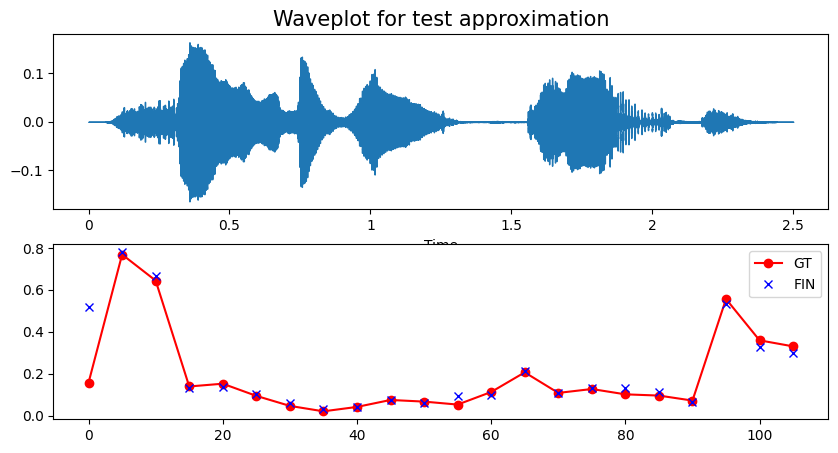

In [20]:
create_waveplot(data,sr,"test",zcr_list_new,approx_new)

## ZCR 

In [21]:
fin_model = load_model("FIN_final_codes/zcr/zcr")

In [22]:
min_mean = 0
min_path = list(tess_path["Path"])[0]
max_mean = 0
max_path = list(tess_path["Path"])[0]


data,sr = librosa.load(list(tess_path["Path"])[0])
data = adjust_length(data,2.5)
frames = divide_into_frames_collective(data)

approx = fin_model.predict(frames, verbose=0)
approx = approx.reshape(-1,)
zcr_list = []
for i, frame in enumerate(frames):
    zcr = librosa.feature.zero_crossing_rate(y=frame, center=False)
    zcr_list.append(zcr[0][0])
error = np.array(zcr_list) - np.array(approx)
inter_mean = np.abs(np.mean(error))
min_mean = inter_mean
max_mean = inter_mean    

In [23]:
errors = []

for path in tess_path["Path"]:
    data,sr = librosa.load(path)
    data = adjust_length(data,2.5)
    frames = divide_into_frames_collective(data)
    
    approx = fin_model.predict(frames, verbose=0)
    approx = approx.reshape(-1,)

    zcr_list = []
    

    for i, frame in enumerate(frames):
        zcr = librosa.feature.zero_crossing_rate(y=frame, center=False)
        zcr_list.append(zcr[0][0])
        
    error = np.array(zcr_list) - np.array(approx)
    
    inter_mean = np.abs(np.mean(error))
    if inter_mean > max_mean:
        max_mean = inter_mean
        max_path = path
    if inter_mean < min_mean:
        min_mean = inter_mean
        min_path = path
    
    errors += list(error)
print(len(errors))

302400


In [24]:
errors = np.array(errors)

### Stats of ZCR FIN errors

In [25]:
np.mean(errors)

-0.05853346926644297

In [26]:
np.std(errors)

0.12869295209449613

In [27]:
skew(errors)

-1.83009087829113

In [28]:
kurtosis(errors)

2.459976262809956

### FIN error plots

Text(0.5, 1.0, 'ZCR error distribution')

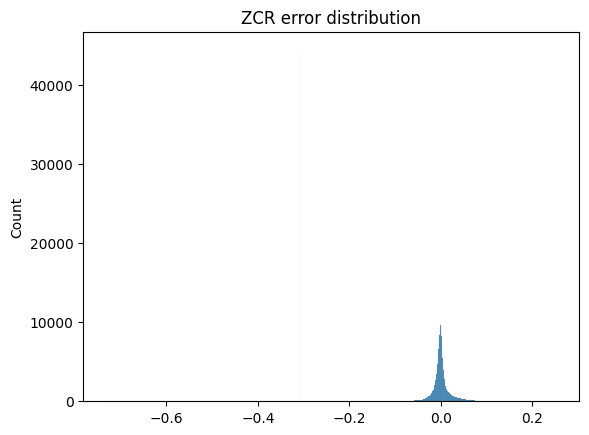

In [29]:
sns.histplot(errors)
plt.title("ZCR error distribution")

#### ZCR plot peculiarity

Text(0.5, 1.0, 'ZCR non-speech frames')

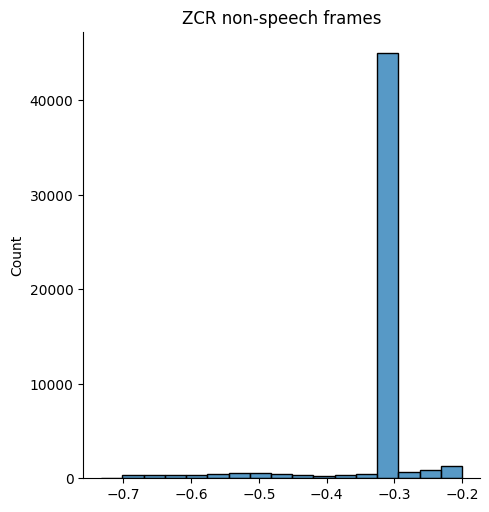

In [31]:
temp_error = []
for i in errors:
    if i < -0.2:
        temp_error.append(i)

sns.displot(temp_error)
plt.title("ZCR non-speech frames")

Text(0.5, 1.0, 'ZCR error plot without non-speech frames')

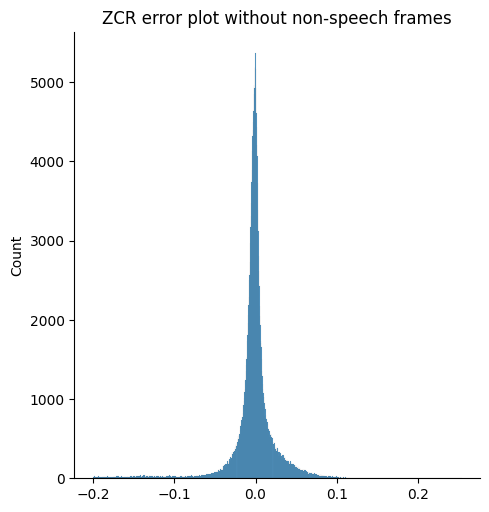

In [32]:
temp_error = []
# for i in errors:
#     if i < -0.2:
#         temp_error.append(i)
# temp_error = temp_error[:10000]

for i in errors:
    if i > -0.2:
        temp_error.append(i)

sns.displot(temp_error)
plt.title("ZCR error plot without non-speech frames")

### FIN tracing plots

4/4 [==============================] - 0s 2ms/step


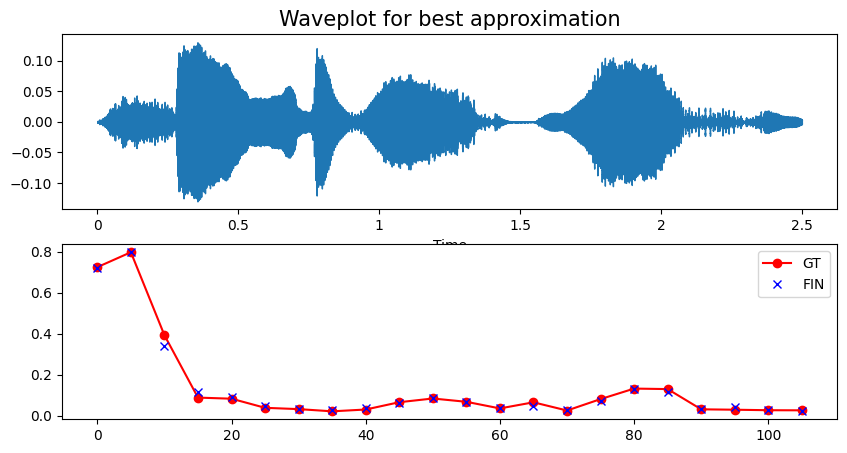

In [33]:
#Best in terms of mean
best_data,sr = librosa.load(min_path)
best_data = adjust_length(best_data,2.5)

frames = divide_into_frames_collective(best_data)
zcr_list = []
for i, frame in enumerate(frames):
    zcr = librosa.feature.zero_crossing_rate(y=frame, center=False)
    zcr_list.append(zcr[0][0])
    
approx = fin_model.predict(frames)
approx = approx.reshape(-1,)

zcr_list_new = []
approx_new = []
for i in range(108):
    if i in index:
        zcr_list_new.append(zcr_list[i])
        approx_new.append(approx[i])

create_waveplot(best_data,sr,"best",zcr_list_new,approx_new)



4/4 [==============================] - 0s 2ms/step


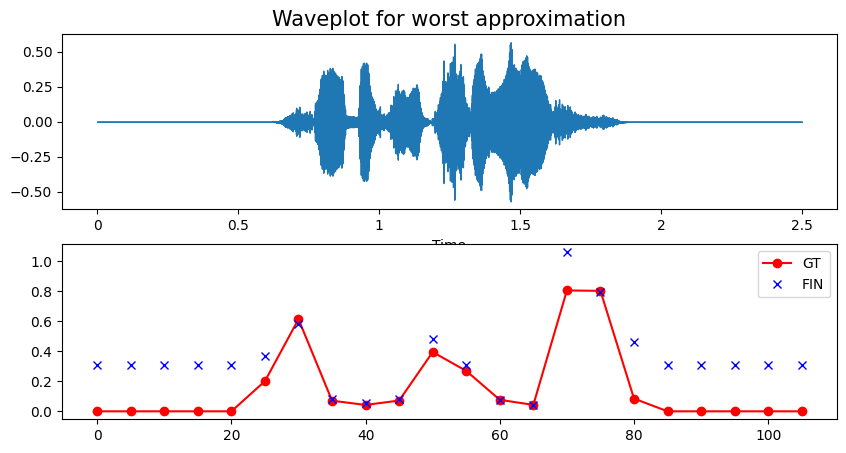

In [34]:
#worst in terms of mean
#Best in terms of mean
worst_data,sr = librosa.load(max_path)
worst_data = adjust_length(worst_data,2.5)

frames = divide_into_frames_collective(worst_data)
zcr_list = []
for i, frame in enumerate(frames):
    zcr = librosa.feature.zero_crossing_rate(y=frame, center=False)
    zcr_list.append(zcr[0][0])
    
approx = fin_model.predict(frames)
approx = approx.reshape(-1,)

zcr_list_new = []
approx_new = []
for i in range(108):
    if i in index:
        zcr_list_new.append(zcr_list[i])
        approx_new.append(approx[i])

create_waveplot(worst_data,sr,"worst",zcr_list_new,approx_new)

## RMS

In [35]:
rms_model = load_model("FIN_final_codes/rms/rmss")

In [36]:
min_mean = 0
min_path = list(tess_path["Path"])[0]
max_mean = 0
max_path = list(tess_path["Path"])[0]


data,sr = librosa.load(list(tess_path["Path"])[0])
data = adjust_length(data,2.5)
frames = divide_into_frames_collective(data)

approx = rms_model.predict(frames, verbose=0)
approx = approx.reshape(-1,)
rms_list = []
for i, frame in enumerate(frames):
    rms = librosa.feature.rms(y=frame, center=False)
    rms_list.append(rms[0][0])
error = np.array(rms_list) - np.array(approx)
inter_mean = np.abs(np.mean(error))
min_mean = inter_mean
max_mean = inter_mean  

In [37]:
rms_errors = []

for path in tess_path["Path"]:
    data,sr = librosa.load(path)
    data = adjust_length(data,2.5)
    frames = divide_into_frames_collective(data)
    
    approx = rms_model.predict(frames, verbose=0)
    approx = approx.reshape(-1,)

    rms_list = []
    

    for i, frame in enumerate(frames):
        rms = librosa.feature.rms(y=frame, center=False)
        rms_list.append(rms[0][0])
        
    error = np.array(rms_list) - np.array(approx)
    
    inter_mean = np.abs(np.mean(error))
    if inter_mean > max_mean:
        max_mean = inter_mean
        max_path = path
    if inter_mean < min_mean:
        min_mean = inter_mean
        min_path = path
    
    rms_errors += list(error)
print(len(rms_errors))

302400


### Stats of RMS FIN errors

In [38]:
rms_mean = np.mean(rms_errors)
rms_mean

0.0011190927

In [39]:
rms_std = np.std(rms_errors)
rms_std

0.006652856

In [40]:
rms_skew = skew(rms_errors)
rms_skew

4.356620571108394

In [41]:
rms_kurtosis = kurtosis(rms_errors)
rms_kurtosis

35.888261929614536

### RMS error plots

Text(0.5, 1.0, 'RMS error distribution')

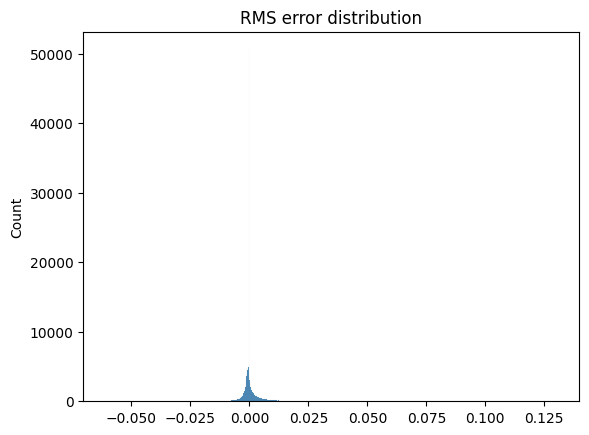

In [42]:
sns.histplot(rms_errors)
plt.title("RMS error distribution")

### RMS tracing plots

4/4 [==============================] - 0s 1ms/step


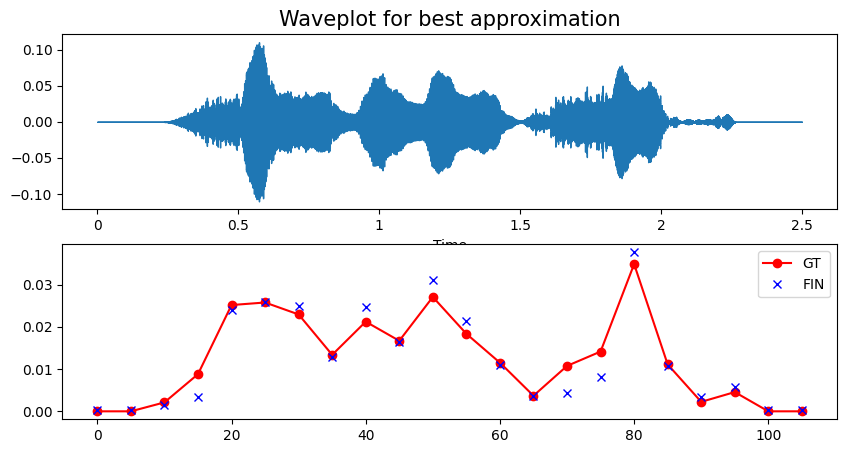

In [43]:
#Best in terms of mean
rms_best_data,sr = librosa.load(min_path)
rms_best_data = adjust_length(rms_best_data,2.5)

frames = divide_into_frames_collective(rms_best_data)
rms_list = []
for i, frame in enumerate(frames):
    rms = librosa.feature.rms(y=frame, center=False)
    rms_list.append(rms[0][0])
    
approx = rms_model.predict(frames)
approx = approx.reshape(-1,)

rms_list_new = []
approx_new = []
for i in range(108):
    if i in index:
        rms_list_new.append(rms_list[i])
        approx_new.append(approx[i])

create_waveplot(rms_best_data,sr,"best",rms_list_new,approx_new)


4/4 [==============================] - 0s 1ms/step


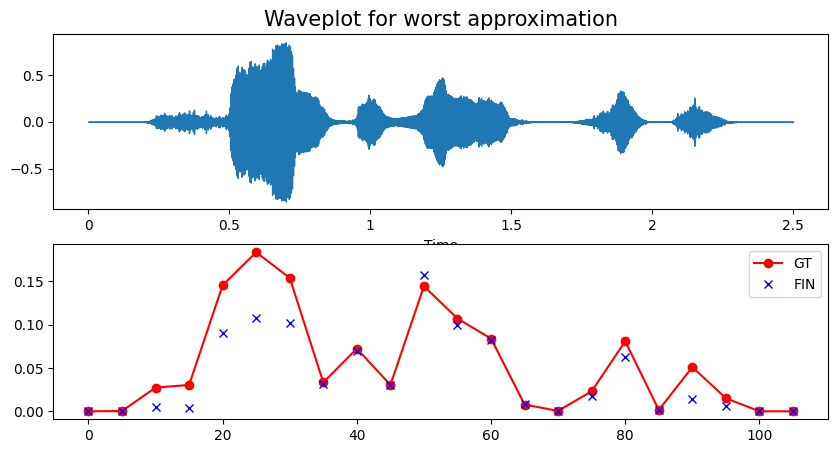

In [44]:
#worst in terms of mean
#Best in terms of mean
rms_worst_data,sr = librosa.load(max_path)
rms_worst_data = adjust_length(rms_worst_data,2.5)

frames = divide_into_frames_collective(rms_worst_data)
rms_list = []
for i, frame in enumerate(frames):
    rms = librosa.feature.rms(y=frame, center=False)
    rms_list.append(rms[0][0])
    
approx = rms_model.predict(frames)
approx = approx.reshape(-1,)

rms_list_new = []
approx_new = []
for i in range(108):
    if i in index:
        rms_list_new.append(rms_list[i])
        approx_new.append(approx[i])

create_waveplot(rms_worst_data,sr,"worst",rms_list_new,approx_new)

## Chroma